In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, GlobalMaxPool1D, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import json

In [3]:
with open("intents.json") as text:
    data = json.load(text)

In [4]:
tags = []
patterns = []
responses = {}
for intent in data["intents"]:
    responses[intent["tag"]] = intent["responses"]
    for lines in intent["patterns"]:
        patterns.append(lines)
        tags.append(intent["tag"])


In [5]:
data = pd.DataFrame({"inputs": patterns, "tags": tags})

In [6]:
data = data.sample(frac=1)

In [7]:
import string
data["inputs"] = data["inputs"].apply(lambda wrd: [ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data["inputs"] = data["inputs"].apply(lambda wrd: "".join(wrd))

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data["inputs"])
train = tokenizer.texts_to_sequences(data["inputs"])

from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(train)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(data["tags"])

In [9]:
input_shape = x_train.shape[1]
print(input_shape)

6


In [10]:
vocabulary = len(tokenizer.word_index)
print("Number of unique words are: ", vocabulary)
output_length = le.classes_.shape[0]
print("Output Length: ", output_length)

Number of unique words are:  48
Output Length:  9


In [11]:
i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1, 10)(i)
x = LSTM(10, return_sequences=True)(x)
x = Flatten()(x)
x = Dense(output_length, activation="softmax")(x)
model = Model(i, x)

In [12]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [13]:
train = model.fit(x_train, y_train, epochs=1000)

Epoch 1/1000
1/1 [==============================] - 4s 4s/step - loss: 2.1966 - accuracy: 0.0741
Epoch 2/1000
1/1 [==============================] - 0s 15ms/step - loss: 2.1951 - accuracy: 0.0741
Epoch 3/1000
1/1 [==============================] - 0s 25ms/step - loss: 2.1937 - accuracy: 0.1481
Epoch 4/1000
1/1 [==============================] - 0s 20ms/step - loss: 2.1922 - accuracy: 0.1111
Epoch 5/1000
1/1 [==============================] - 0s 27ms/step - loss: 2.1907 - accuracy: 0.2222
Epoch 6/1000
1/1 [==============================] - 0s 28ms/step - loss: 2.1891 - accuracy: 0.2222
Epoch 7/1000
1/1 [==============================] - 0s 28ms/step - loss: 2.1876 - accuracy: 0.2593
Epoch 8/1000
1/1 [==============================] - 0s 28ms/step - loss: 2.1860 - accuracy: 0.2593
Epoch 9/1000
1/1 [==============================] - 0s 32ms/step - loss: 2.1844 - accuracy: 0.1852
Epoch 10/1000
1/1 [==============================] - 0s 19ms/step - loss: 2.1827 - accuracy: 0.1852
Epoch 11/10

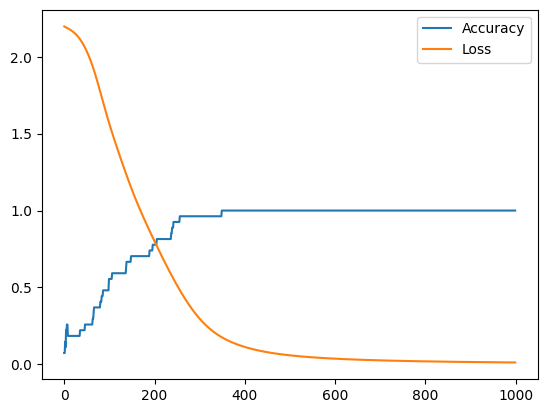

In [14]:
plt.plot(train.history["accuracy"], label="Accuracy")
plt.plot(train.history["loss"], label="Loss")
plt.legend()

In [15]:
import random

while True:
    text_p = []
    prediction_input = input("You : ")
    
    prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
    prediction_input = " ".join(prediction_input)
    text_p.append(prediction_input)

    prediction_input = tokenizer.texts_to_sequences(text_p)
    prediction_input = np.array(prediction_input).reshape(-1)
    prediction_input = pad_sequences([prediction_input], input_shape)

    output = model.predict(prediction_input)
    output = output.argmax()

    response_tag = le.inverse_transform([output])[0]
    print(response_tag)
    
    if prediction_input == "quit":
        break
    else:
        print("Bot : ", random.choice(responses[response_tag]))